In [147]:
import os
from collections import defaultdict
import numpy as np
import scipy.stats
import torch
from torch.distributions import constraints
from matplotlib import pyplot
%matplotlib inline

import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.infer.autoguide import AutoDelta
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete

smoke_test = ('CI' in os.environ)

pyro.enable_validation(True)
import pickle
# Adapted from https://pyro.ai/examples/gmm.html#Predicting-membership-using-discrete-inference

In [75]:
with open('station_posterior_samples.pkl', 'rb') as fp:
    d_beta = pickle.load(fp)

In [79]:
data = torch.tensor([1.])
for i in d_beta.values():
    t = torch.tensor(i)
    data = torch.cat((data,t),0)
data.shape

torch.Size([7001])

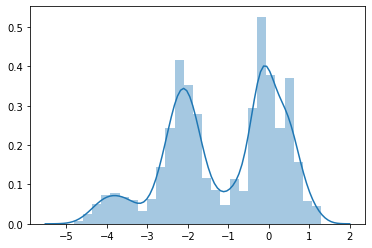

In [78]:
sns.distplot(data)

# GMM
We have sampled the beta station posteriors for the station plus hour model and we wish to use the latent variable to find stations that have similar demand rate characteristics. Above we took 100 samples from each of the 70 stations and visualised the density. There appear to be 3 modes so we posit K = 3 categories in a mixture model. \

Since we had assumed Gaussian priors for the latent variables, we can try and fit a gaussian mixture model to the samples. For $N$ data samples, the likelihood for a particular sample is:
$$ Pr(x|\mu,\sigma) = \Sigma_{1}^{K} \pi_k \mathcal{N}(x|\mu_k,\sigma_k)$$
$$Pr(\mu) = Dirichlet(0.5*1_K)$$
$$Pr(\sigma) = LogNormal(4,2)$$




In [80]:
K = 3  # Fixed number of components.

@config_enumerate
def model(data):
    # Global variables.
    weights = pyro.sample('weights', dist.Dirichlet(0.5 * torch.ones(K)))
    scale = pyro.sample('scale', dist.LogNormal(4., 2.))
    with pyro.plate('components', K):
        locs = pyro.sample('locs', dist.Normal(0., 10.))

    with pyro.plate('data', len(data)):
        # Local variables.
        assignment = pyro.sample('assignment', dist.Categorical(weights))
        pyro.sample('obs', dist.Normal(locs[assignment], scale), obs=data)

In [81]:
optim = pyro.optim.Adam({'lr': 0.1, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=1)

In [82]:
def init_loc_fn(site):
    if site["name"] == "weights":
        # Initialize weights to uniform.
        return torch.ones(K) / K
    if site["name"] == "scale":
        return (data.var() / 2).sqrt()
    if site["name"] == "locs":
        return data[torch.multinomial(torch.ones(len(data)) / len(data), K)]
    raise ValueError(site["name"])

def initialize(seed):
    global global_guide, svi
    pyro.set_rng_seed(seed)
    pyro.clear_param_store()
    global_guide = AutoDelta(poutine.block(model, expose=['weights', 'locs', 'scale']),
                             init_loc_fn=init_loc_fn)
    svi = SVI(model, global_guide, optim, loss=elbo)
    return svi.loss(model, global_guide, data)

# Choose the best among 100 random initializations.
loss, seed = min((initialize(seed), seed) for seed in range(100))
initialize(seed)
print('seed = {}, initial_loss = {}'.format(seed, loss))

seed = 37, initial_loss = 11917.2216796875


In [83]:
# Register hooks to monitor gradient norms.
gradient_norms = defaultdict(list)
for name, value in pyro.get_param_store().named_parameters():
    value.register_hook(lambda g, name=name: gradient_norms[name].append(g.norm().item()))

losses = []
for i in range(200 if not smoke_test else 2):
    loss = svi.step(data)
    losses.append(loss)
    print('.' if i % 100 else '\n', end='')


...................................................................................................
...................................................................................................

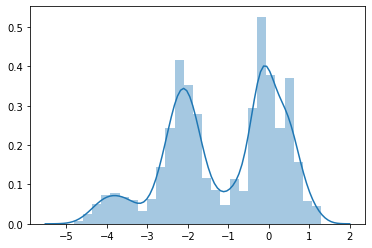

In [96]:
import seaborn as sns
sns.distplot(data)

In [97]:
map_estimates = global_guide(data)
weights = map_estimates['weights']
locs = map_estimates['locs']
scale = map_estimates['scale']
print('weights = {}'.format(weights.data.numpy()))
print('locs = {}'.format(locs.data.numpy()))
print('scale = {}'.format(scale.data.numpy()))

weights = [0.46489948 0.2658561  0.26924443]
locs = [-2.4224222e+00 -1.7666232e-03 -1.7632728e-03]
scale = 0.6637429594993591


In [116]:
guide_trace = poutine.trace(global_guide).get_trace(data)  # record the globals
trained_model = poutine.replay(model, trace=guide_trace)  # replay the globals

def classifier(data, temperature=0):
    inferred_model = infer_discrete(trained_model, temperature=temperature,
                                    first_available_dim=-3)  # avoid conflict with data plate
    trace = poutine.trace(inferred_model).get_trace(data)
    return trace.nodes["assignment"]["value"]



The trained model can be used to do classification of data points into the categories. (I dont know why it predicts only two categories here)

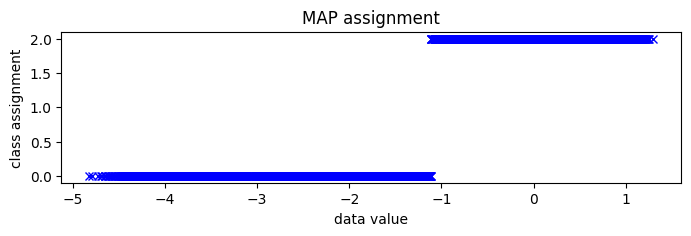

In [119]:
assignment = classifier(data)
pyplot.figure(figsize=(8, 2), dpi=100).set_facecolor('white')
pyplot.plot(data.numpy(),assignment.numpy(),'bx')
pyplot.title('MAP assignment')
pyplot.xlabel('data value')
pyplot.ylabel('class assignment');

Obtaining the categories each station and storing it in a dictionary. We can do this for other latent variables in a similar way.

In [146]:
stat_cat = []
N_samples_per_beta = 100

for i in range(0,len(assignment),N_samples_per_beta):
    l = list(assignment[i:i+100])
    a = max(set(l),key=l.count)
    stat_cat.append(a)
    

In [ ]:
station_category_dict ={}
count = 0
for key in d_beta:
    station_category_dict[key] = stat_cat[count]
    count +=1